# Linear Regression with PyTorch
In this section we'll use PyTorch's machine learning model to progressively develop a best-fit line for a given set of data points. Like most linear regression algorithms, we're seeking to minimize the error between our model and the actual data, using a <em>loss function</em> like mean-squared-error.

<img src='../Images/linear-regression-residuals.png' width='400' style="display: inline-block"><br>

Image source: <a href='https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png'>https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png</a>

To start, we'll develop a collection of data points that appear random, but that fit a known linear equation $y = 2x+1$

## Perform standard imports

In [22]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!

import numpy as np
import matplotlib.pyplot as plt

## Create a column matrix of X values
We can create tensors right away rather than convert from NumPy arrays.

In [2]:
X = torch.linspace(1,50,50).reshape(-1,1)

# Equivalent to
# X = torch.unsqueeze(torch.linspace(1,50,50), dim=1)

## Create a "random" array of error values
We want 50 random integer values that collectively cancel each other out.

In [3]:
torch.manual_seed(71) # to obtain reproducible results
e = torch.randint(-8,9,(50,1),dtype=torch.float)
print(e.sum())

tensor(0.)


## Create a column matrix of y values
Here we'll set our own parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$, plus the error amount.<br><strong><tt>y</tt></strong> will have the same shape as <strong><tt>X</tt></strong> and <strong><tt>e</tt></strong>

In [4]:
y = 2*X + 1 + e
print(y.shape)

torch.Size([50, 1])


## Plot the results
We have to convert tensors to NumPy arrays just for plotting.

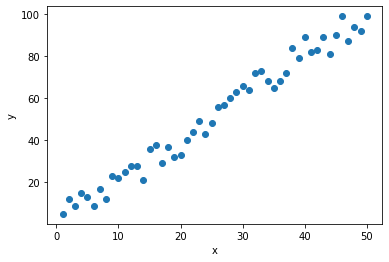

In [5]:
plt.scatter(X.numpy(), y.numpy())
plt.ylabel('y')
plt.xlabel('x');

Note that when we created tensor $X$, we did <em>not</em> pass <tt>requires_grad=True</tt>. This means that $y$ doesn't have a gradient function, and <tt>y.backward()</tt> won't work. Since PyTorch is not tracking operations, it doesn't know the relationship between $X$ and $y$.

## Simple linear model
As a quick demonstration we'll show how the built-in <tt>nn.Linear()</tt> model preselects weight and bias values at random.

In [6]:
torch.manual_seed(59)

model = nn.Linear(in_features=1, out_features=1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.1060]], requires_grad=True)
Parameter containing:
tensor([0.9638], requires_grad=True)


Without seeing any data, the model sets a random weight of 0.1060 and a bias of 0.9638.

## Model classes
PyTorch lets us define models as object classes that can store multiple model layers. In upcoming sections we'll set up several neural network layers, and determine how each layer should perform its forward pass to the next layer. For now, though, we only need a single <tt>linear</tt> layer.

In [7]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

<div class="alert alert-info"><strong>NOTE:</strong> The "Linear" model layer used here doesn't really refer to linear regression. Instead, it describes the type of neural network layer employed. Linear layers are also called "fully connected" or "dense" layers. Going forward our models may contain linear layers, convolutional layers, and more.</div>

When <tt>Model</tt> is instantiated, we need to pass in the size (dimensions) of the incoming and outgoing features. For our purposes we'll use (1,1).<br>As above, we can see the initial hyperparameters.

In [8]:
torch.manual_seed(59)
model = Model(1, 1)
print(model)
print('Weight:', model.linear.weight.item())
print('Bias:  ', model.linear.bias.item())

Model(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Weight: 0.10597813129425049
Bias:   0.9637961387634277


As models become more complex, it may be better to iterate over all the model parameters:

In [9]:
for name, param in model.named_parameters():
    print(name, '\t', param.item())

linear.weight 	 0.10597813129425049
linear.bias 	 0.9637961387634277


<div class="alert alert-info"><strong>NOTE:</strong> In the above example we had our Model class accept arguments for the number of input and output features.<br>For simplicity we can hardcode them into the Model:
         
<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(1,1)<br><br>
model = Model()
</font></tt><br><br>

Alternatively we can use default arguments:

<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, in_dim=1, out_dim=1):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(in_dim,out_dim)<br><br>
model = Model()<br>
<em>\# or</em><br>
model = Model(i,o)</font></tt>
</div>

Now let's see the result when we pass a tensor into the model.

In [10]:
x = torch.tensor([2.0])
print(model.forward(x))   # equivalent to print(model(x))

tensor([1.1758], grad_fn=<AddBackward0>)


which is confirmed with $f(x) = (0.1060)(2.0)+(0.9638) = 1.1758$

## Plot the initial model
We can plot the untrained model against our dataset to get an idea of our starting point.

In [11]:
x1 = np.array([X.min(),X.max()])
print(x1)

[ 1. 50.]


In [12]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Initial weight: {w1:.8f}, Initial bias: {b1:.8f}')
print()

y1 = x1*w1 + b1
print(y1)

Initial weight: 0.10597813, Initial bias: 0.96379614

[1.0697743 6.2627025]


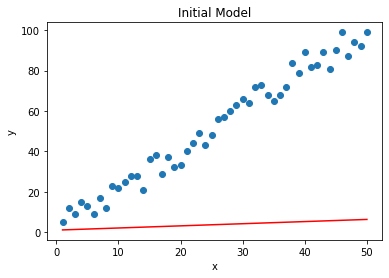

In [13]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1,y1,'r')
plt.title('Initial Model')
plt.ylabel('y')
plt.xlabel('x');

## Set the loss function
We could write our own function to apply a Mean Squared Error (MSE) that follows<br>

$\begin{split}MSE &= \frac {1} {n} \sum_{i=1}^n {(y_i - \hat y_i)}^2 \\
&= \frac {1} {n} \sum_{i=1}^n {(y_i - (wx_i + b))}^2\end{split}$<br>

Fortunately PyTorch has it built in.<br>
<em>By convention, you'll see the variable name "criterion" used, but feel free to use something like "linear_loss_func" if that's clearer.</em>

In [14]:
criterion = nn.MSELoss()

## Set the optimization
Here we'll use <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>Stochastic Gradient Descent</a> (SGD) with an applied <a href='https://en.wikipedia.org/wiki/Learning_rate'>learning rate</a> (lr) of 0.001. Recall that the learning rate tells the optimizer how much to adjust each parameter on the next round of calculations. Too large a step and we run the risk of overshooting the minimum, causing the algorithm to diverge. Too small and it will take a long time to converge.

For more complicated (multivariate) data, you might also consider passing optional <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum'><tt>momentum</tt></a> and <a href='https://en.wikipedia.org/wiki/Tikhonov_regularization'><tt>weight_decay</tt></a> arguments. Momentum allows the algorithm to "roll over" small bumps to avoid local minima that can cause convergence too soon. Weight decay (also called an L2 penalty) applies to biases.

For more information, see <a href='https://pytorch.org/docs/stable/optim.html'><strong><tt>torch.optim</tt></strong></a>

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

# You'll sometimes see this as
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

## Train the model
An <em>epoch</em> is a single pass through the entire dataset. We want to pick a sufficiently large number of epochs to reach a plateau close to our known parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take:</strong><br>

1. Set a reasonably large number of passes<br>
<tt><font color=black>epochs = 50</font></tt><br>
2. Create a list to store loss values. This will let us view our progress afterward.<br>
<tt><font color=black>losses = []</font></tt><br>
<tt><font color=black>for i in range(epochs):</font></tt><br>
3. Bump "i" so that the printed report starts at 1<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;i+=1</font></tt><br>
4. Create a prediction set by running "X" through the current model parameters<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;y_pred = model.forward(X)</font></tt><br>
5. Calculate the loss<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;loss = criterion(y_pred, y)</font></tt><br>
6. Add the loss value to our tracking list<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;losses.append(loss)</font></tt><br>
7. Print the current line of results<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;print(f'epoch: {i:2} loss: {loss.item():10.8f}')</font></tt><br>
8. Gradients accumulate with every backprop. To prevent compounding we need to reset the stored gradient for each new epoch.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;optimizer.zero_grad()</font></tt><br>
9. Now we can backprop<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;loss.backward()</font></tt><br>
10. Finally, we can update the hyperparameters of our model<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;optimizer.step()</font></tt>
</div>

In [16]:
epochs = 50
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X)
    loss = criterion(y_pred, y)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}  weight: {model.linear.weight.item():10.8f}  \
bias: {model.linear.bias.item():10.8f}') 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 3057.21679688  weight: 0.10597813  bias: 0.96379614
epoch:  2  loss: 1588.53100586  weight: 3.33490038  bias: 1.06046367
epoch:  3  loss: 830.30010986  weight: 1.01483274  bias: 0.99226278
epoch:  4  loss: 438.85241699  weight: 2.68179965  bias: 1.04252183
epoch:  5  loss: 236.76152039  weight: 1.48402119  bias: 1.00766504
epoch:  6  loss: 132.42912292  weight: 2.34460592  bias: 1.03396463
epoch:  7  loss: 78.56572723  weight: 1.72622538  bias: 1.01632178
epoch:  8  loss: 50.75775909  weight: 2.17050409  bias: 1.03025162
epoch:  9  loss: 36.40123367  weight: 1.85124576  bias: 1.02149546
epoch: 10  loss: 28.98922729  weight: 2.08060074  bias: 1.02903891
epoch: 11  loss: 25.16238213  weight: 1.91576838  bias: 1.02487016
epoch: 12  loss: 23.18647385  weight: 2.03416562  bias: 1.02911627
epoch: 13  loss: 22.16612816  weight: 1.94905841  bias: 1.02731562
epoch: 14  loss: 21.63911057  weight: 2.01017213  bias: 1.02985907
epoch: 15  loss: 21.36677170  weight: 1.96622372  bias

## Plot the loss values
Let's see how loss changed over time

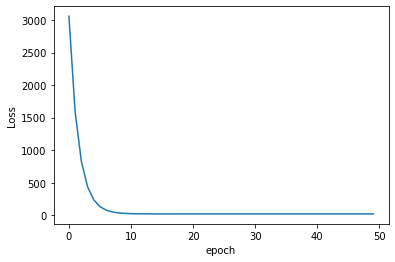

In [17]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

## Plot the result
Now we'll derive <tt>y1</tt> from the new model to plot the most recent best-fit line.

In [18]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Current weight: {w1:.8f}, Current bias: {b1:.8f}')
print()

y1 = x1*w1 + b1
print(x1)
print(y1)

Current weight: 1.98381913, Current bias: 1.05575156

[ 1. 50.]
[  3.0395708 100.246704 ]


In [20]:
print(x1)

[ 1. 50.]


In [21]:
print(y1)

[  3.0395708 100.246704 ]


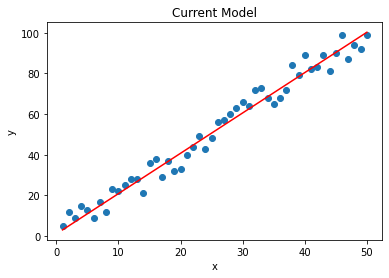

In [19]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1,y1,'r')
plt.title('Current Model')
plt.ylabel('y')
plt.xlabel('x');